# Week 1 assignment: Linear regression using Python

## 1. Load and explore the data

In [177]:
# Import essential libraries for analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
from sklearn.cluster import KMeans
from statsmodels.formula.api import ols
from sklearn.metrics import silhouette_score
import nltk
import string
from nltk.stem import WordNetLemmatizer

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('turtle_reviews.csv')

In [3]:
df.isnull().sum()

gender                    0
age                       0
remuneration (k£)         0
spending_score (1-100)    0
loyalty_points            0
education                 0
language                  0
platform                  0
product                   0
review                    0
summary                   0
dtype: int64

In [4]:
# Display descriptive statistics
df.describe().round(2)

age  remuneration (k£)  spending_score (1-100)  loyalty_points  \
count  2000.00            2000.00                 2000.00         2000.00   
mean     39.49              48.08                   50.00         1578.03   
std      13.57              23.12                   26.09         1283.24   
min      17.00              12.30                    1.00           25.00   
25%      29.00              30.34                   32.00          772.00   
50%      38.00              47.15                   50.00         1276.00   
75%      49.00              63.96                   73.00         1751.25   
max      72.00             112.34                   99.00         6847.00   

        product  
count   2000.00  
mean    4320.52  
std     3148.94  
min      107.00  
25%     1589.25  
50%     3624.00  
75%     6654.00  
max    11086.00

## 2. Drop columns

In [5]:
# Drop unnecessary columns
df = df.drop(['language', 'platform'], axis=1)

## 3. Rename columns

In [6]:
# Rename columns for clarity
df.rename(columns={'remuneration (k£)': 'income', 'spending_score (1-100)': 'spending_score'}, inplace=True)

In [7]:
# Check gender distribution
df['gender'].value_counts()

gender
Female    1120
Male       880
Name: count, dtype: int64

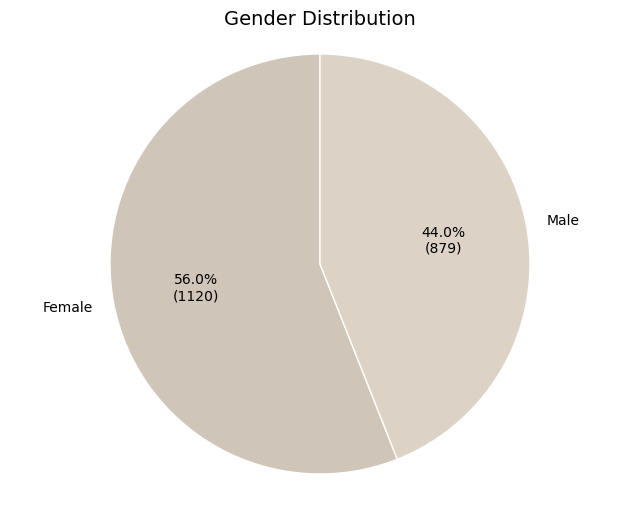

In [8]:
# Define pastel colors
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']

# Plot gender distribution pie chart
gender_counts = df['gender'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, colors=beige_pastels[:len(gender_counts)],
        autopct=lambda p: f'{p:.1f}%\n({int(p * gender_counts.sum() / 100)})', startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('Gender Distribution', fontsize=14)
plt.axis('equal')
plt.show()

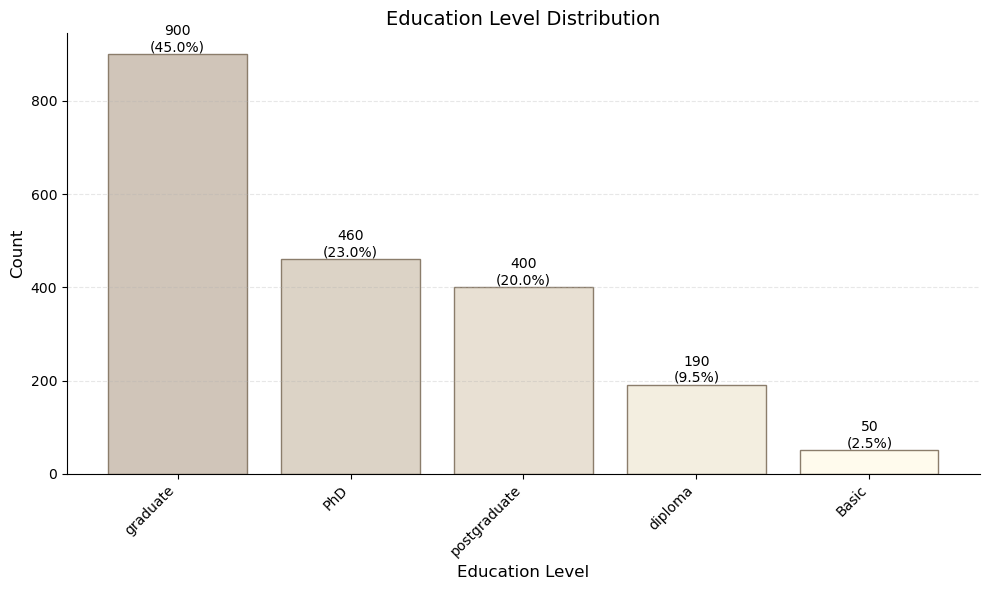

In [9]:
# Plot education level distribution
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
education_counts = df['education'].value_counts(dropna=False).fillna('Unknown')
total = education_counts.sum()

plt.figure(figsize=(10, 6))
bars = plt.bar(education_counts.index, education_counts.values, color=beige_pastels[:len(education_counts)],
               edgecolor='#8b7d6b', linewidth=1)
for bar, count in zip(bars, education_counts.values):
    percent = count / total * 100
    plt.text(bar.get_x() + bar.get_width() / 2, count + 0.5, f'{count}\n({percent:.1f}%)',
             ha='center', va='bottom', fontsize=10)

plt.title('Education Level Distribution', fontsize=14)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

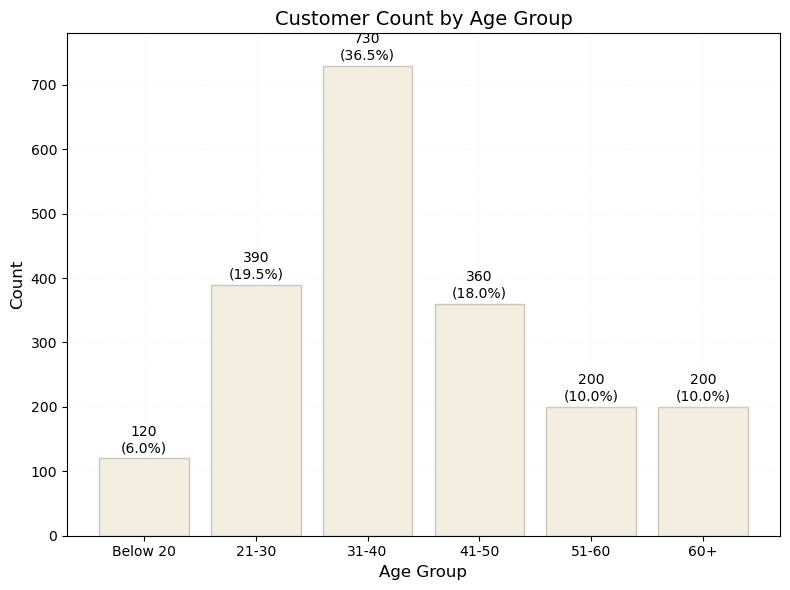

In [10]:
# Create and plot age group distribution
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 30, 40, 50, 60, np.inf],
                        labels=['Below 20', '21-30', '31-40', '41-50', '51-60', '60+'], right=False)
age_group_counts = df['age_group'].value_counts().sort_index()
total = age_group_counts.sum()

plt.figure(figsize=(8, 6))
bars = plt.bar(age_group_counts.index, age_group_counts.values, color=beige_pastels[3], edgecolor=beige_pastels[0])
for bar, count in zip(bars, age_group_counts.values):
    percent = count / total * 100
    plt.text(bar.get_x() + bar.get_width() / 2, count + 5, f'{count}\n({percent:.1f}%)',
             ha='center', va='bottom', fontsize=10)

plt.title('Customer Count by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.3, color=beige_pastels[3])
plt.ylim(0, age_group_counts.max() + 50)
plt.tight_layout()
plt.show()

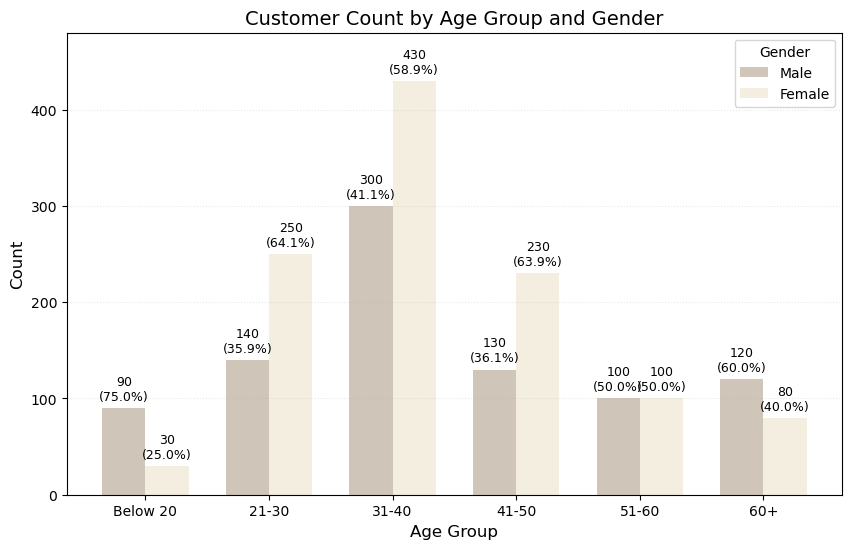

In [11]:
# Plot age group distribution by gender
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 30, 40, 50, 60, np.inf],
                        labels=['Below 20', '21-30', '31-40', '41-50', '51-60', '60+'], right=False)
age_gender_counts = df.groupby(['age_group', 'gender']).size().unstack(fill_value=0)
total = age_gender_counts.sum(axis=1)

plt.figure(figsize=(10, 6))
x = np.arange(len(age_gender_counts))
width = 0.35
plt.bar(x - width/2, age_gender_counts['Male'], width, label='Male', color=beige_pastels[0])
plt.bar(x + width/2, age_gender_counts['Female'], width, label='Female', color=beige_pastels[3])

for i in range(len(age_gender_counts)):
    for j, gender in enumerate(['Male', 'Female']):
        count = age_gender_counts[gender].iloc[i]
        percent = count / total.iloc[i] * 100 if total.iloc[i] > 0 else 0
        plt.text(x[i] + (j - 0.5) * width, count + 5, f'{count}\n({percent:.1f}%)',
                 ha='center', va='bottom', fontsize=9)

plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Customer Count by Age Group and Gender', fontsize=14)
plt.xticks(x, age_gender_counts.index)
plt.legend(title='Gender')
plt.grid(True, linestyle=':', alpha=0.3, axis='y')
plt.ylim(0, age_gender_counts.max().max() + 50)
plt.show()

In [12]:
# Preview DataFrame
df.head()

gender  age  income  spending_score  loyalty_points education  product  \
0    Male   18   12.30              39             210  graduate      453   
1    Male   23   12.30              81             524  graduate      466   
2  Female   22   13.12               6              40  graduate      254   
3  Female   25   13.12              77             562  graduate      263   
4  Female   33   13.94              40             366  graduate      291   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary age_group  
0  The fact that 50% of this space is wasted on a...  Below 20  
1  Another worthless Dungeon Master's screen from...     21-30  
2                    pretty, but also pretty useless     21-30  
3                                         Five Stars     21-30  
4                                         Money trap     31-40

In [13]:
df.describe().round(2)

age   income  spending_score  loyalty_points   product
count  2000.00  2000.00         2000.00         2000.00   2000.00
mean     39.49    48.08           50.00         1578.03   4320.52
std      13.57    23.12           26.09         1283.24   3148.94
min      17.00    12.30            1.00           25.00    107.00
25%      29.00    30.34           32.00          772.00   1589.25
50%      38.00    47.15           50.00         1276.00   3624.00
75%      49.00    63.96           73.00         1751.25   6654.00
max      72.00   112.34           99.00         6847.00  11086.00

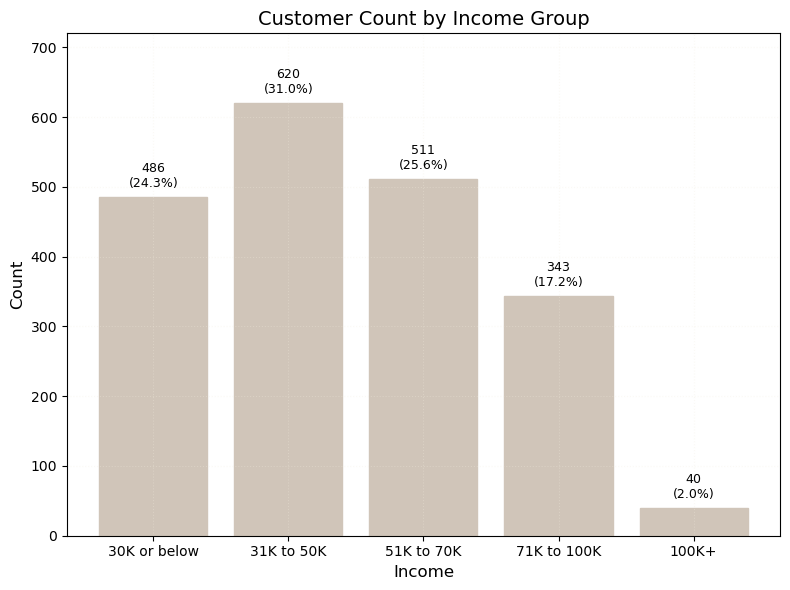

In [29]:
# Plot income group distribution
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
df['income_group'] = pd.cut(df['income'], bins=[0, 30, 50, 70, 100, np.inf],
                           labels=['30K or below', '31K to 50K', '51K to 70K', '71K to 100K', '100K+'], right=False)
income_group_counts = df['income_group'].value_counts().sort_index()
total = income_group_counts.sum()

plt.figure(figsize=(8, 6))
bars = plt.bar(income_group_counts.index, income_group_counts.values, color=beige_pastels[0], edgecolor=beige_pastels[0])
for bar, count in zip(bars, income_group_counts.values):
    percent = count / total * 100
    plt.text(bar.get_x() + bar.get_width() / 2, count + 10, f'{count}\n({percent:.1f}%)',
             ha='center', va='bottom', fontsize=9)

plt.title('Customer Count by Income Group', fontsize=14)
plt.xlabel('Income', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.3, color=beige_pastels[3])
plt.ylim(0, income_group_counts.max() + 100)
plt.tight_layout()
plt.show()

In [15]:
# Display DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   gender          2000 non-null   object  
 1   age             2000 non-null   int64   
 2   income          2000 non-null   float64 
 3   spending_score  2000 non-null   int64   
 4   loyalty_points  2000 non-null   int64   
 5   education       2000 non-null   object  
 6   product         2000 non-null   int64   
 7   review          2000 non-null   object  
 8   summary         2000 non-null   object  
 9   age_group       2000 non-null   category
 10  income_group    2000 non-null   category
dtypes: category(2), float64(1), int64(4), object(4)
memory usage: 145.1+ KB


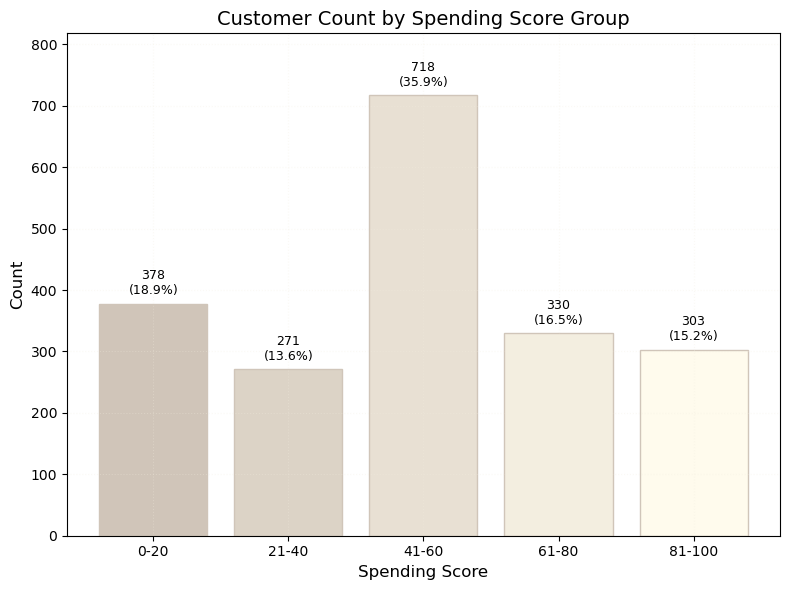

In [16]:
# Plot spending score group distribution
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
df['spending_group'] = pd.cut(df['spending_score'], bins=[0, 20, 40, 60, 80, 100],
                             labels=['0-20', '21-40', '41-60', '61-80', '81-100'], right=True)
spending_group_counts = df['spending_group'].value_counts().sort_index()
total = spending_group_counts.sum()

plt.figure(figsize=(8, 6))
bars = plt.bar(spending_group_counts.index, spending_group_counts.values, color=beige_pastels[:len(spending_group_counts)],
               edgecolor=beige_pastels[0])
for bar, count in zip(bars, spending_group_counts.values):
    percent = count / total * 100
    plt.text(bar.get_x() + bar.get_width() / 2, count + 10, f'{count}\n({percent:.1f}%)',
             ha='center', va='bottom', fontsize=9)

plt.title('Customer Count by Spending Score Group', fontsize=14)
plt.xlabel('Spending Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.3, color=beige_pastels[3])
plt.ylim(0, spending_group_counts.max() + 100)
plt.tight_layout()
plt.show()

In [17]:
df.describe().round(2)

age   income  spending_score  loyalty_points   product
count  2000.00  2000.00         2000.00         2000.00   2000.00
mean     39.49    48.08           50.00         1578.03   4320.52
std      13.57    23.12           26.09         1283.24   3148.94
min      17.00    12.30            1.00           25.00    107.00
25%      29.00    30.34           32.00          772.00   1589.25
50%      38.00    47.15           50.00         1276.00   3624.00
75%      49.00    63.96           73.00         1751.25   6654.00
max      72.00   112.34           99.00         6847.00  11086.00

In [33]:
# Sense-check DataFrame
reviews.info()
reviews.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   object 
 1   age             2000 non-null   int64  
 2   income(k£)      2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   object 
 6   product         2000 non-null   int64  
 7   review          2000 non-null   object 
 8   summary         2000 non-null   object 
 9   age_group       2000 non-null   object 
 10  income_group    2000 non-null   object 
 11  spending_group  2000 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 187.6+ KB


age  income(k£)  spending_score  loyalty_points   product
count  2000.00     2000.00         2000.00         2000.00   2000.00
mean     39.49       48.08           50.00         1578.03   4320.52
std      13.57       23.12           26.09         1283.24   3148.94
min      17.00       12.30            1.00           25.00    107.00
25%      29.00       30.34           32.00          772.00   1589.25
50%      38.00       47.15           50.00         1276.00   3624.00
75%      49.00       63.96           73.00         1751.25   6654.00
max      72.00      112.34           99.00         6847.00  11086.00

In [20]:
# Check for duplicates
duplicates = reviews[reviews.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [gender, age, income(k£), spending_score, loyalty_points, education, product, review, summary, age_group, income_group, spending_group]
Index: []


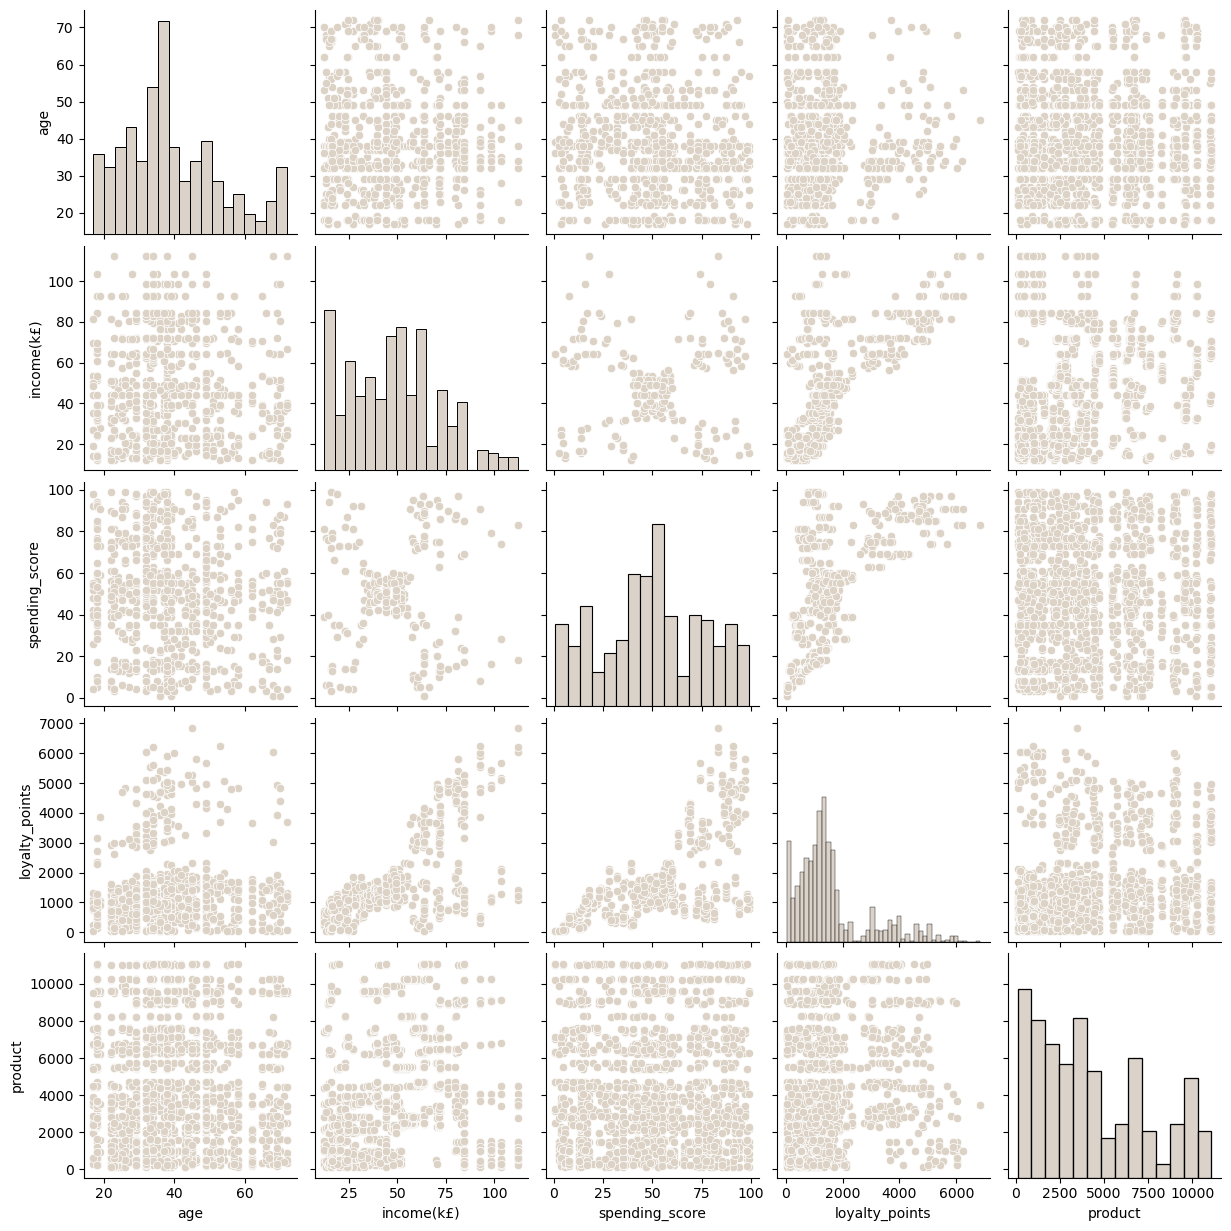

In [21]:
# Plot pairplot for relationships
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
sns.pairplot(reviews, diag_kws={'color': beige_pastels[0]}, plot_kws={'color': beige_pastels[1]})
plt.show()

## 5. Linear regression

### 5a) spending vs loyalty

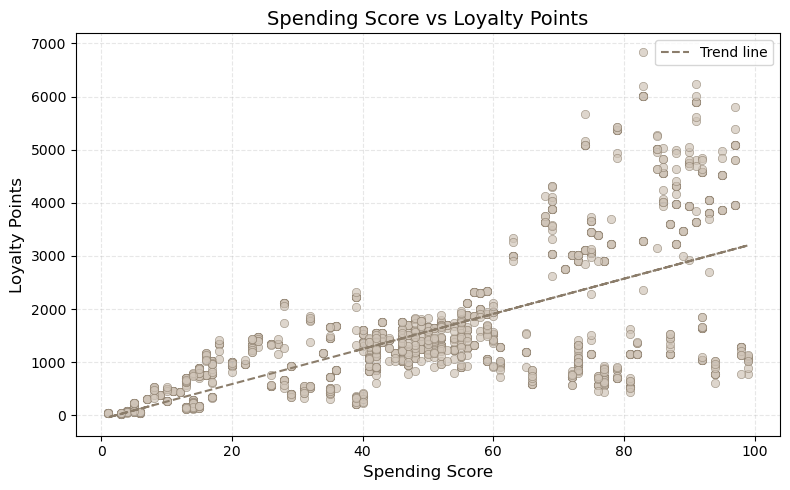

In [22]:
# Scatter plot with trendline
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
x = reviews['spending_score']
y = reviews['loyalty_points']

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color=beige_pastels[0], alpha=0.7, edgecolor='#8b7d6b', linewidth=0.5)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='#8b7d6b', linestyle='--', label='Trend line')

plt.title('Spending Score vs Loyalty Points', fontsize=14)
plt.xlabel('Spending Score', fontsize=12)
plt.ylabel('Loyalty Points', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
df.describe().round(2)

age   income  spending_score  loyalty_points   product
count  2000.00  2000.00         2000.00         2000.00   2000.00
mean     39.49    48.08           50.00         1578.03   4320.52
std      13.57    23.12           26.09         1283.24   3148.94
min      17.00    12.30            1.00           25.00    107.00
25%      29.00    30.34           32.00          772.00   1589.25
50%      38.00    47.15           50.00         1276.00   3624.00
75%      49.00    63.96           73.00         1751.25   6654.00
max      72.00   112.34           99.00         6847.00  11086.00

In [24]:
df.describe().round(2)

age   income  spending_score  loyalty_points   product
count  2000.00  2000.00         2000.00         2000.00   2000.00
mean     39.49    48.08           50.00         1578.03   4320.52
std      13.57    23.12           26.09         1283.24   3148.94
min      17.00    12.30            1.00           25.00    107.00
25%      29.00    30.34           32.00          772.00   1589.25
50%      38.00    47.15           50.00         1276.00   3624.00
75%      49.00    63.96           73.00         1751.25   6654.00
max      72.00   112.34           99.00         6847.00  11086.00

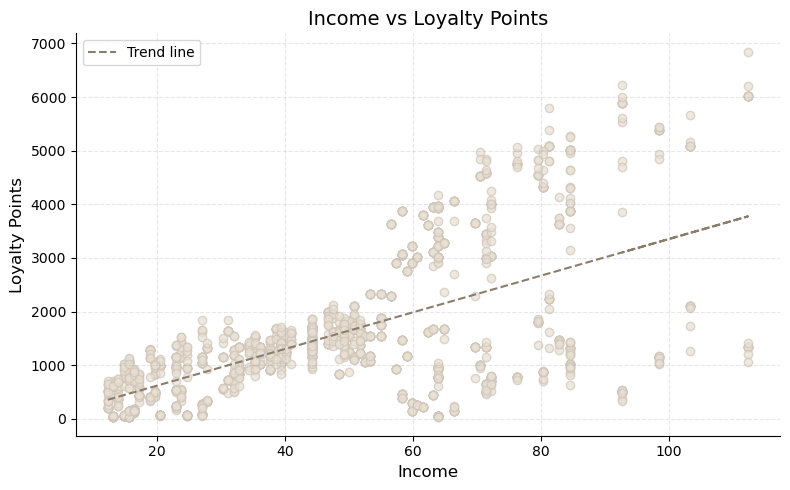

In [35]:
# Scatter plot with trendline
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
x = reviews['income(k£)']
y = reviews['loyalty_points']

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color=beige_pastels[2], alpha=0.7, edgecolor=beige_pastels[0])
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color='#8b7d6b', linestyle='--', label='Trend line')

plt.title('Income vs Loyalty Points', fontsize=14)
plt.xlabel('Income', fontsize=12)
plt.ylabel('Loyalty Points', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

### 5b) Income vs loyalty

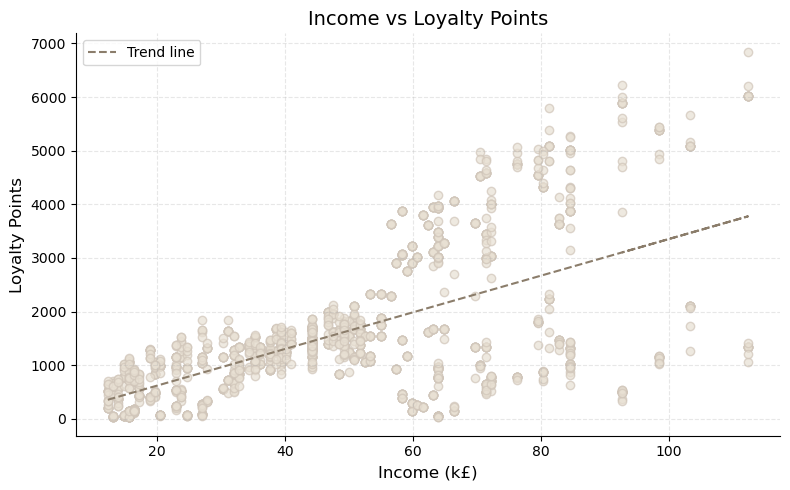

In [26]:
# Scatter plot with trendline
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
x = reviews['income(k£)']
y = reviews['loyalty_points']

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color=beige_pastels[2], alpha=0.7, edgecolor=beige_pastels[0])
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color='#8b7d6b', linestyle='--', label='Trend line')

plt.title('Income vs Loyalty Points', fontsize=14)
plt.xlabel('Income (k£)', fontsize=12)
plt.ylabel('Loyalty Points', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   gender          2000 non-null   object  
 1   age             2000 non-null   int64   
 2   income          2000 non-null   float64 
 3   spending_score  2000 non-null   int64   
 4   loyalty_points  2000 non-null   int64   
 5   education       2000 non-null   object  
 6   product         2000 non-null   int64   
 7   review          2000 non-null   object  
 8   summary         2000 non-null   object  
 9   age_group       2000 non-null   category
 10  income_group    2000 non-null   category
 11  spending_group  2000 non-null   category
dtypes: category(3), float64(1), int64(4), object(4)
memory usage: 147.2+ KB


In [39]:
# Rename column for simplicity
reviews = reviews.rename(columns={'income(k£)': 'income'})

# OLS regression: income vs loyalty_points
model1 = ols('loyalty_points ~ income', data=reviews).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     1222.
Date:                Sun, 13 Apr 2025   Prob (F-statistic):          2.43e-209
Time:                        11:54:03   Log-Likelihood:                -16674.
No. Observations:                2000   AIC:                         3.335e+04
Df Residuals:                    1998   BIC:                         3.336e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -65.6865     52.171     -1.259      0.2

 Summary:
    1. Slope (Coefficient for income) 34.19 → For every 1-unit increase in income, loyalty_points increase by 34.19 on average.

This suggests a strong positive relationship—higher income is associated with earning more loyalty points.

    2. R² (0.379 or 37.9%) The model explains 37.9% of the variation in loyalty_points based on income.

This indicates a moderate relationship—income is an important factor, but other factors also influence loyalty points.

    3. p-value (0.000) Since the p-value is extremely small (< 0.05), the effect of income on loyalty points is statistically significant.

This means there's a very low probability that this result is due to random chance

In [41]:
# Print regression metrics
print("Parameters:", model1.params)
print("Standard Errors:", model1.bse)
print("Predicted Values:", model1.predict())

Parameters: Intercept   -65.686513
income       34.187825
dtype: float64
Standard Errors: Intercept    52.170717
income        0.977925
dtype: float64
Predicted Values: [ 354.82374068  354.82374068  382.85775758 ... 3102.15739671 3298.39551499
 3102.15739671]


In [43]:
# Predict loyalty_points using model
y_pred1 = model1.predict(reviews[['income']])
print(y_pred1)

0        354.823741
1        354.823741
2        382.857758
3        382.857758
4        410.891774
           ...     
1995    2821.817228
1996    3102.157397
1997    3102.157397
1998    3298.395515
1999    3102.157397
Length: 2000, dtype: float64


In [45]:
# OLS regression: age vs loyalty_points
model2 = ols('loyalty_points ~ age', data=reviews).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.606
Date:                Sun, 13 Apr 2025   Prob (F-statistic):             0.0577
Time:                        11:54:55   Log-Likelihood:                -17150.
No. Observations:                2000   AIC:                         3.430e+04
Df Residuals:                    1998   BIC:                         3.431e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1736.5177     88.249     19.678      0.0

In [47]:
# Print regression metrics
print("Parameters:", model2.params)
print("Standard Errors:", model2.bse)
print("Predicted Values:", model2.predict())

Parameters: Intercept    1736.517739
age            -4.012805
dtype: float64
Standard Errors: Intercept    88.248731
age           2.113177
dtype: float64
Predicted Values: [1664.2872467  1644.22322095 1648.2360261  ... 1600.0823643  1600.0823643
 1608.1079746 ]


### 5c) age vs loyalty

In [49]:
# Predict loyalty_points using model
y_pred2 = model2.predict(reviews[['age']])
print(y_pred2)

0       1664.287247
1       1644.223221
2       1648.236026
3       1636.197611
4       1604.095169
           ...     
1995    1588.043949
1996    1563.967118
1997    1600.082364
1998    1600.082364
1999    1608.107975
Length: 2000, dtype: float64


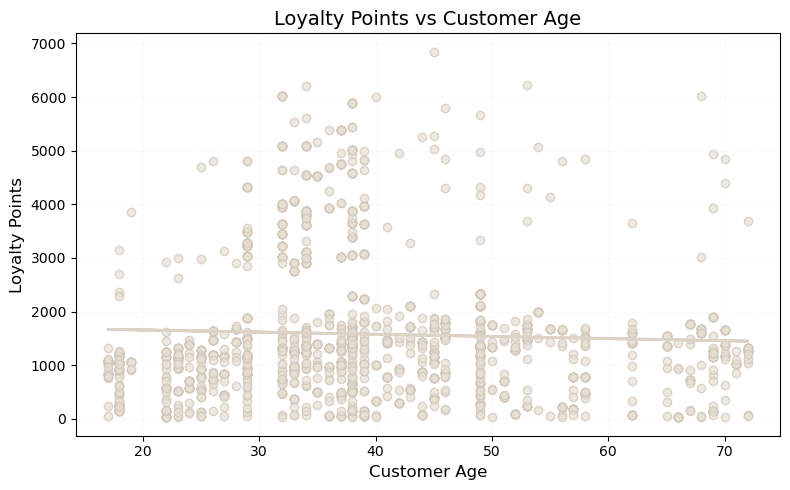

In [51]:
# Scatter plot with regression line
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
x = reviews['age']
y = reviews['loyalty_points']
y_pred = model2.predict(reviews[['age']])

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color=beige_pastels[2], alpha=0.7, edgecolor=beige_pastels[0])
plt.plot(x, y_pred, color=beige_pastels[1], linewidth=2)

plt.title('Loyalty Points vs Customer Age', fontsize=14)
plt.xlabel('Customer Age', fontsize=12)
plt.ylabel('Loyalty Points', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3, color=beige_pastels[3])
plt.tight_layout()
plt.show()

# Week 2 assignment: Exploring the structure using decision trees.

In [53]:
# Drop text columns
df2 = reviews.drop(['product', 'review', 'summary'], axis=1)

In [55]:
# Encode gender
df2['gender'] = df2['gender'].map({'Male': 0, 'Female': 1})

In [57]:
# Verify education column
print(df2['education'].value_counts())
print("Data type:", df2['education'].dtype)
print("Unique values:", df2['education'].unique())

education
graduate        900
PhD             460
postgraduate    400
diploma         190
Basic            50
Name: count, dtype: int64
Data type: object
Unique values: ['graduate' 'PhD' 'diploma' 'postgraduate' 'Basic']


In [59]:
# Display DataFrame info
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   int64  
 1   age             2000 non-null   int64  
 2   income          2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   object 
 6   age_group       2000 non-null   object 
 7   income_group    2000 non-null   object 
 8   spending_group  2000 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 140.8+ KB


In [61]:
# Encode education
df2['education'] = df2['education'].replace({'Basic': 'non-degree', 'diploma': 'non-degree'})
df2['education'] = df2['education'].map({'non-degree': 0, 'graduate': 1, 'postgraduate': 2, 'PhD': 3})

In [63]:
# Create binary loyalty based on median
threshold = df2['loyalty_points'].median()
df2['loyalty_points_binary'] = (df2['loyalty_points'] > threshold).astype(int)
print("Median threshold:", threshold)
print(df2[['loyalty_points', 'loyalty_points_binary']].head())

Median threshold: 1276.0
   loyalty_points  loyalty_points_binary
0             210                      0
1             524                      0
2              40                      0
3             562                      0
4             366                      0


In [65]:
# Create binary loyalty based on mean
threshold = df2['loyalty_points'].mean()
df2['loyalty_points_binary'] = (df2['loyalty_points'] > threshold).astype(int)
print("Mean threshold:", threshold)

Mean threshold: 1578.032


In [67]:
# Create binary loyalty based on 75th percentile
threshold = df2['loyalty_points'].quantile(0.75)
df2['loyalty_points_binary'] = (df2['loyalty_points'] > threshold).astype(int)
print("75th percentile threshold:", threshold)

75th percentile threshold: 1751.25


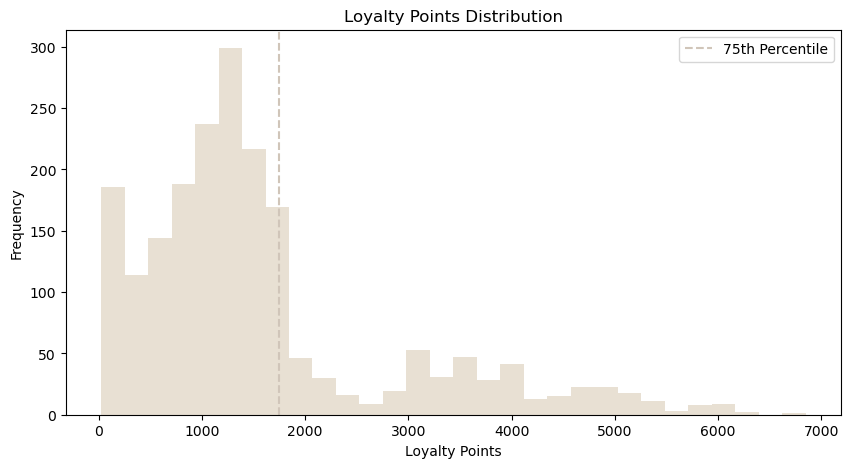

count    2000.000000
mean     1578.032000
std      1283.239705
min        25.000000
25%       772.000000
50%      1276.000000
75%      1751.250000
max      6847.000000
Name: loyalty_points, dtype: float64


In [69]:
# Plot loyalty points distribution
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
plt.figure(figsize=(10, 5))
plt.hist(df2['loyalty_points'], bins=30, color=beige_pastels[2])
plt.axvline(df2['loyalty_points'].quantile(0.75), color=beige_pastels[0], linestyle='--', label='75th Percentile')
plt.xlabel('Loyalty Points')
plt.ylabel('Frequency')
plt.title('Loyalty Points Distribution')
plt.legend()
plt.show()
print(df2['loyalty_points'].describe())

In [71]:
# Create binary loyalty based on 75th percentile
threshold = df2['loyalty_points'].quantile(0.75)
df2['loyalty_points_binary'] = (df2['loyalty_points'] > threshold).astype(int)
print("75th percentile threshold:", threshold)
print(df2[['loyalty_points', 'loyalty_points_binary']].head())
print("Binary loyalty counts:\n", df2['loyalty_points_binary'].value_counts())

75th percentile threshold: 1751.25
   loyalty_points  loyalty_points_binary
0             210                      0
1             524                      0
2              40                      0
3             562                      0
4             366                      0
Binary loyalty counts:
 loyalty_points_binary
0    1500
1     500
Name: count, dtype: int64


In [77]:
# Define features and target
y = df2['loyalty_points_binary']
X = df2[['gender', 'age', 'income', 'spending_score', 'education']]

In [79]:
# Verify features
print(X)

      gender  age  income  spending_score  education
0          0   18   12.30              39          1
1          0   23   12.30              81          1
2          1   22   13.12               6          1
3          1   25   13.12              77          1
4          1   33   13.94              40          1
...      ...  ...     ...             ...        ...
1995       1   37   84.46              69          3
1996       1   43   92.66               8          3
1997       0   34   92.66              91          1
1998       0   34   98.40              16          3
1999       0   32   92.66               8          3

[2000 rows x 5 columns]


In [83]:
# Verify and encode education only if needed
if df2['education'].dtype == 'object':
    # Standardize education values
    df2['education'] = df2['education'].str.lower().str.strip().replace({'basic': 'non-degree', 'diploma': 'non-degree'})
    # Encode to integers
    df2['education'] = df2['education'].map({'non-degree': 0, 'graduate': 1, 'postgraduate': 2, 'phd': 3})
else:
    print("Education already encoded:", df2['education'].unique())

Education already encoded: [1 3 0 2]


## 2. Create train and test data sets.

In [85]:
# Split data for classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [87]:
# Preview training target
y_train.head()

836     0
575     1
557     1
1235    0
1360    0
Name: loyalty_points_binary, dtype: int32

In [89]:
# Preview training features
X_train.head()

gender  age  income  spending_score  education
836        1   40   27.88              17          0
575        1   32   72.16              86          2
557        1   32   63.96              78          2
1235       1   23   27.06              81          3
1360       1   55   64.78              35          1

## 3. Create Decision tree regressor

In [91]:
# Train decision tree classifier
dTree = DecisionTreeClassifier(max_depth=4, class_weight='balanced', random_state=42)
dTree.fit(X_train, y_train)
predictions = dTree.predict(X_test)

In [93]:
# Evaluate classifier
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))
print("F1-Score:", f1_score(y_test, predictions))

Accuracy: 0.9433333333333334
Precision: 0.8058823529411765
Recall: 0.9927536231884058
F1-Score: 0.8896103896103896


In [95]:
# Train decision tree regressor (verify if intended)
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)
print("R^2 Score:", regressor.score(X_test, y_test))

R^2 Score: 0.9153020892151327


In [97]:
# Test sample prediction
i = 10
sample = X_test.iloc[i]
print("Sample features:\n", sample)
print("Actual label:", y_test.iloc[i])
print("Predicted label:", predictions[i])

Sample features:
 gender             1.00
age               50.00
income            36.08
spending_score    50.00
education          2.00
Name: 56, dtype: float64
Actual label: 0
Predicted label: 0


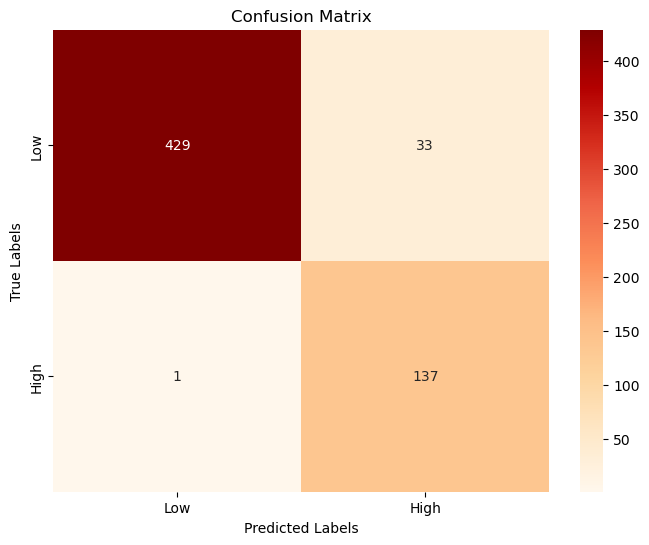

In [99]:
# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='OrRd', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## 4. Fit and plot final model.

Accuracy: 0.9433333333333334
Precision: 0.8058823529411765
Recall: 0.9927536231884058
F1-Score: 0.8896103896103896


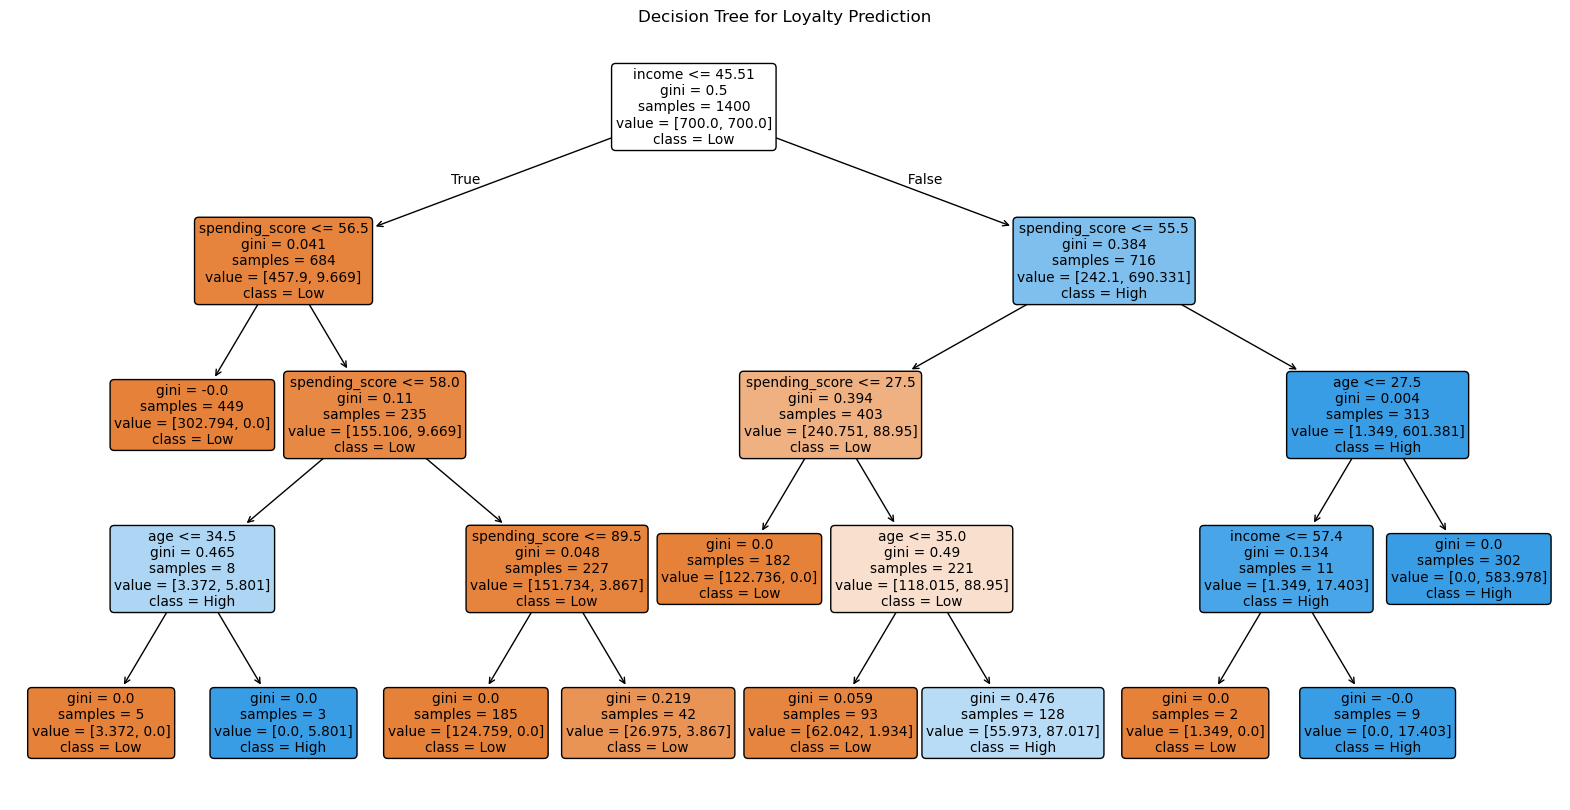

In [101]:
# Train and evaluate decision tree with visualization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
dTree = DecisionTreeClassifier(max_depth=4, class_weight='balanced', random_state=42)
dTree.fit(X_train, y_train)
predictions = dTree.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))
print("F1-Score:", f1_score(y_test, predictions))

plt.figure(figsize=(20, 10))
plot_tree(dTree, filled=True, feature_names=X.columns, class_names=['Low', 'High'], rounded=True)
plt.title('Decision Tree for Loyalty Prediction')
plt.show()

# Week 3 assignment: Clustering with *k*-means using Python

In [103]:
# Load reviews (optional)
df3 = pd.read_csv('reviews.csv')
df3.head()

gender  age  income(k£)  spending_score  loyalty_points education  product  \
0    Male   18       12.30              39             210  graduate      453   
1    Male   23       12.30              81             524  graduate      466   
2  Female   22       13.12               6              40  graduate      254   
3  Female   25       13.12              77             562  graduate      263   
4  Female   33       13.94              40             366  graduate      291   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary age_group  income_group  \
0  The fact that 50% of this space is wasted on a...  Below 20  30K or below   
1  Another worthless Dungeon Master's screen from...     21-30  30K or below   
2                    pretty, but also pretty useless     21-30  30K or below   
3                                         Five Stars     21-30  30K or below   
4                                         Money trap     31-40  30K or below   

  spending_group  
0          21-40  
1         81-100  
2           0-20  
3          61-80  
4          21-40

In [105]:
# Preview DataFrame
df3.head()

gender  age  income(k£)  spending_score  loyalty_points education  product  \
0    Male   18       12.30              39             210  graduate      453   
1    Male   23       12.30              81             524  graduate      466   
2  Female   22       13.12               6              40  graduate      254   
3  Female   25       13.12              77             562  graduate      263   
4  Female   33       13.94              40             366  graduate      291   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary age_group  income_group  \
0  The fact that 50% of this space is wasted on a...  Below 20  30K or below   
1  Another worthless Dungeon Master's screen from...     21-30  30K or below   
2                    pretty, but also pretty useless     21-30  30K or below   
3                                         Five Stars     21-30  30K or below   
4                                         Money trap     31-40  30K or below   

  spending_group  
0          21-40  
1         81-100  
2           0-20  
3          61-80  
4          21-40

In [107]:
# Display DataFrame info
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   object 
 1   age             2000 non-null   int64  
 2   income(k£)      2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   object 
 6   product         2000 non-null   int64  
 7   review          2000 non-null   object 
 8   summary         2000 non-null   object 
 9   age_group       2000 non-null   object 
 10  income_group    2000 non-null   object 
 11  spending_group  2000 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 187.6+ KB


In [109]:
# Display descriptive statistics
df3.describe()

age   income(k£)  spending_score  loyalty_points       product
count  2000.000000  2000.000000     2000.000000     2000.000000   2000.000000
mean     39.495000    48.079060       50.000000     1578.032000   4320.521500
std      13.573212    23.123984       26.094702     1283.239705   3148.938839
min      17.000000    12.300000        1.000000       25.000000    107.000000
25%      29.000000    30.340000       32.000000      772.000000   1589.250000
50%      38.000000    47.150000       50.000000     1276.000000   3624.000000
75%      49.000000    63.960000       73.000000     1751.250000   6654.000000
max      72.000000   112.340000       99.000000     6847.000000  11086.000000

## 3. Elbow and silhoutte methods

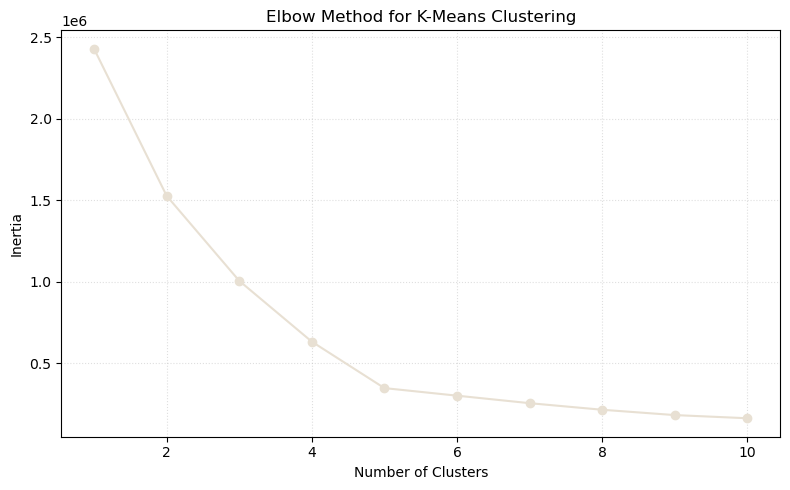

In [117]:


# Elbow method for K-Means
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
X_cluster = df[['income', 'spending_score']]
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', color=beige_pastels[2])
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means Clustering')
plt.grid(True, linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()

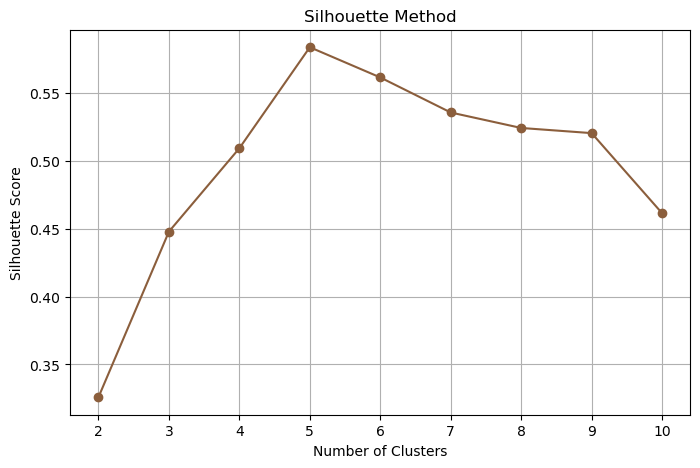

In [125]:
# Silhouette method for K-Means
X_cluster = df[['income', 'spending_score']]
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    silhouette_scores.append(silhouette_score(X_cluster, kmeans.labels_))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='#8B5E3C')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

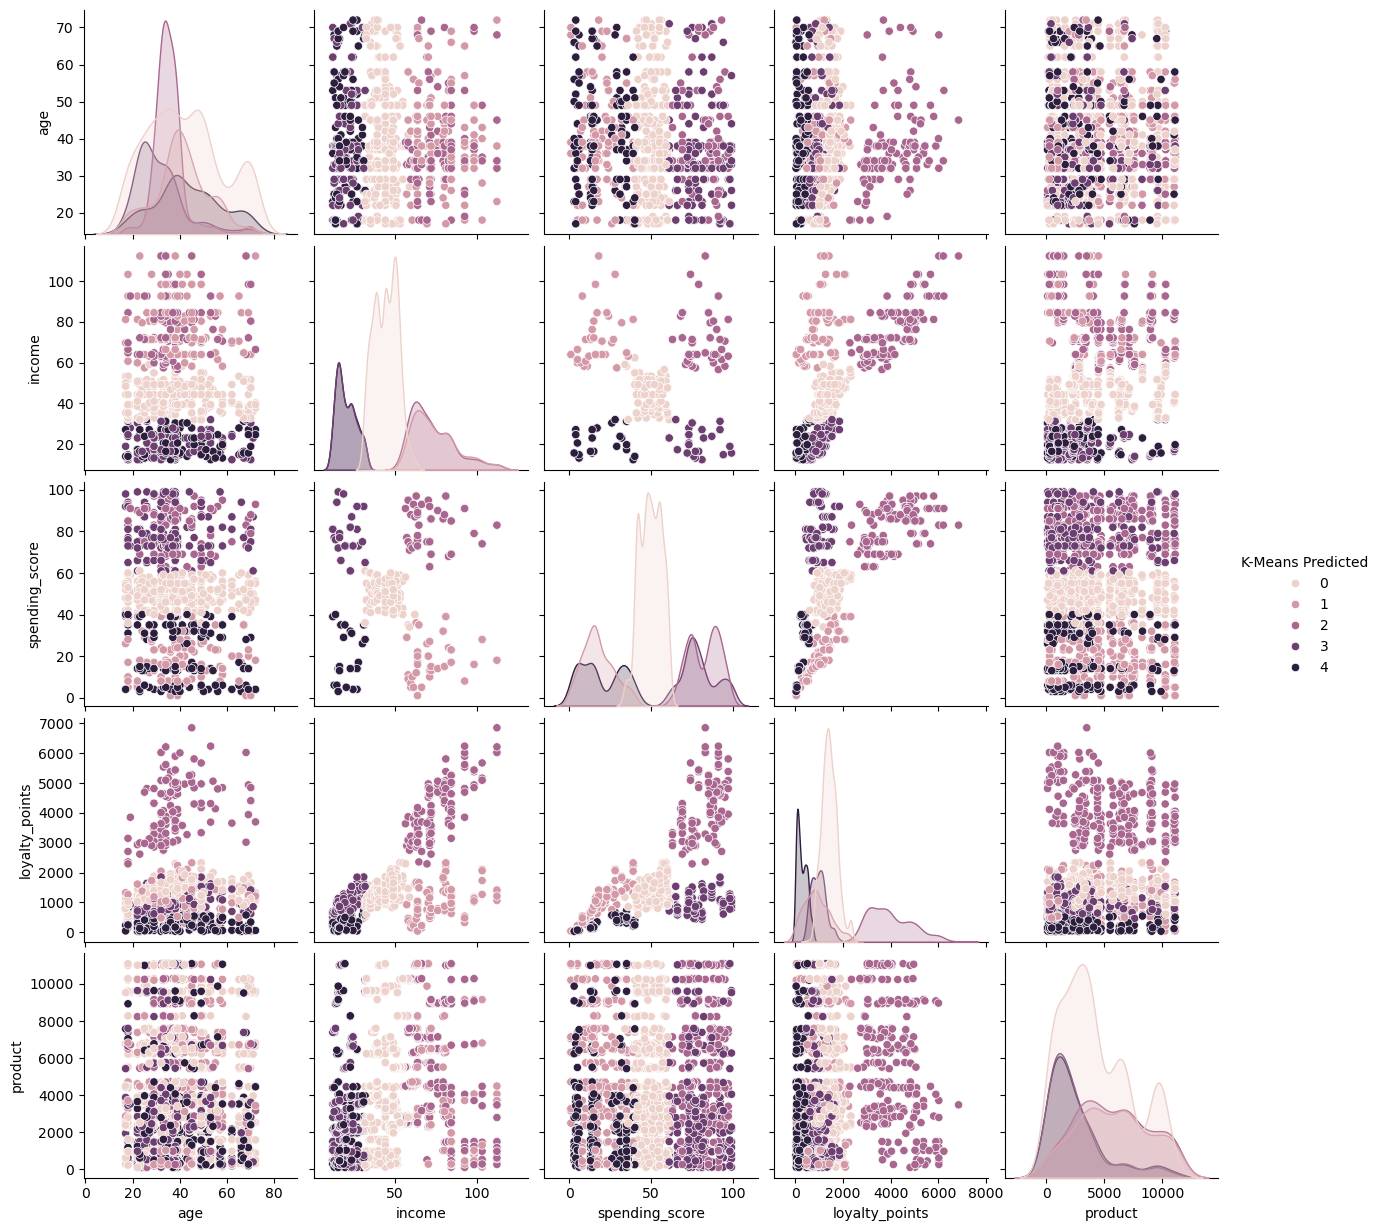

In [129]:
# K-Means clustering with pairplot
X_cluster = df[['income', 'spending_score']]
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
df['K-Means Predicted'] = kmeans.fit_predict(X_cluster)

sns.pairplot(df, hue='K-Means Predicted', diag_kind='kde')
plt.show()

In [131]:
# Display cluster sizes
print(df['K-Means Predicted'].value_counts())

K-Means Predicted
0    774
2    356
1    330
4    271
3    269
Name: count, dtype: int64


In [139]:
df3 = df3.rename(columns={'income(k£)': 'income'})
# Preview DataFrame
df3.head()

gender  age  income  spending_score  loyalty_points education  product  \
0    Male   18   12.30              39             210  graduate      453   
1    Male   23   12.30              81             524  graduate      466   
2  Female   22   13.12               6              40  graduate      254   
3  Female   25   13.12              77             562  graduate      263   
4  Female   33   13.94              40             366  graduate      291   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary age_group  income_group  \
0  The fact that 50% of this space is wasted on a...  Below 20  30K or below   
1  Another worthless Dungeon Master's screen from...     21-30  30K or below   
2                    pretty, but also pretty useless     21-30  30K or below   
3                                         Five Stars     21-30  30K or below   
4                                         Money trap     31-40  30K or below   

  spending_group  
0          21-40  
1         81-100  
2           0-20  
3          61-80  
4          21-40

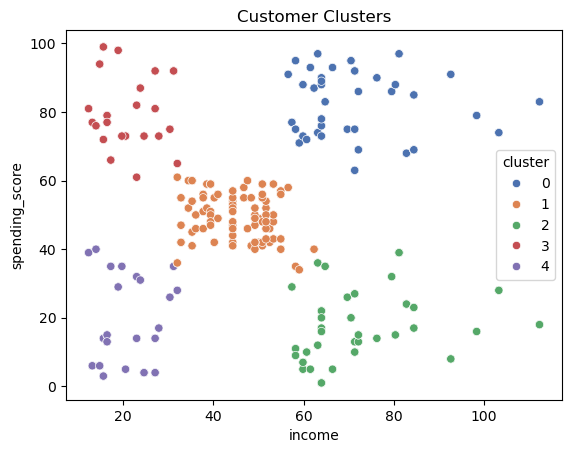

cluster
1    774
0    356
2    330
4    271
3    269
Name: count, dtype: int64


In [141]:
# K-Means clustering with scatter plot
X_cluster = df3[['income', 'spending_score']]
kmeans = KMeans(n_clusters=5, random_state=42)
df3['cluster'] = kmeans.fit_predict(X_cluster)

sns.scatterplot(x='income', y='spending_score', hue='cluster', data=df3, palette='deep')
plt.title('Customer Clusters')
plt.show()
print(df3['cluster'].value_counts())

In [143]:
# Assign education to clustering DataFrame
df3['education'] = df2['education'].reindex(df3.index)

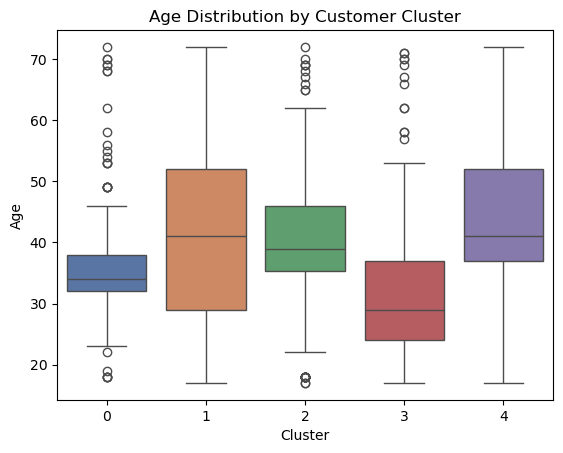

In [145]:
# Boxplot of age by cluster
sns.boxplot(x='cluster', y='age', data=df3, palette='deep')
plt.title('Age Distribution by Customer Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.show()

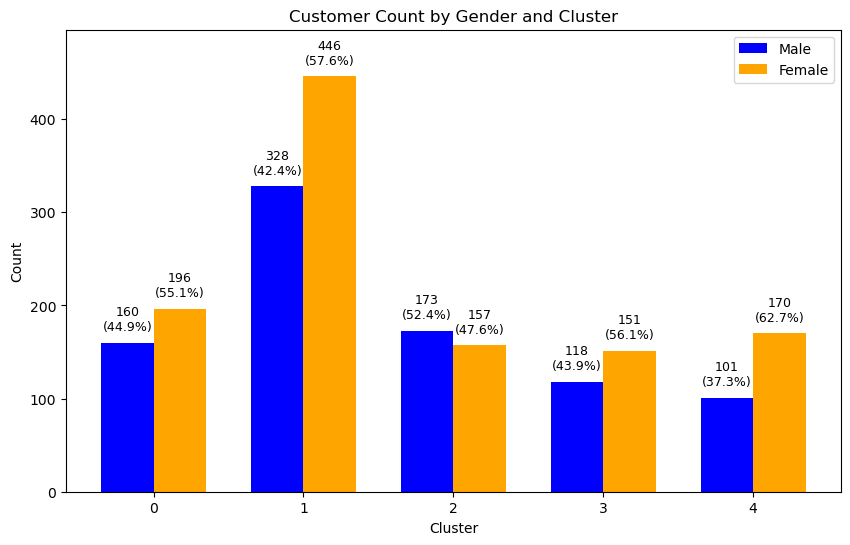

In [147]:
# Bar plot of gender by cluster
count_data = df3.groupby(['cluster', 'gender']).size().unstack(fill_value=0)
total = count_data.sum(axis=1)

plt.figure(figsize=(10, 6))
x = range(len(count_data))
width = 0.35
plt.bar([i - width/2 for i in x], count_data['Male'], width, label='Male', color='blue')
plt.bar([i + width/2 for i in x], count_data['Female'], width, label='Female', color='orange')

for i in range(len(count_data)):
    for j, gender in enumerate(['Male', 'Female']):
        count = count_data[gender].iloc[i]
        percent = count / total.iloc[i] * 100 if total.iloc[i] > 0 else 0
        plt.text(i + (j - 0.5) * width, count + 10, f'{count}\n({percent:.1f}%)',
                 ha='center', va='bottom', fontsize=9)

plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Customer Count by Gender and Cluster')
plt.xticks(x, count_data.index)
plt.legend()
plt.ylim(0, count_data.max().max() + 50)
plt.show()

In [149]:
# Display columns
print(df3.columns)

Index(['gender', 'age', 'income', 'spending_score', 'loyalty_points',
       'education', 'product', 'review', 'summary', 'age_group',
       'income_group', 'spending_group', 'cluster'],
      dtype='object')


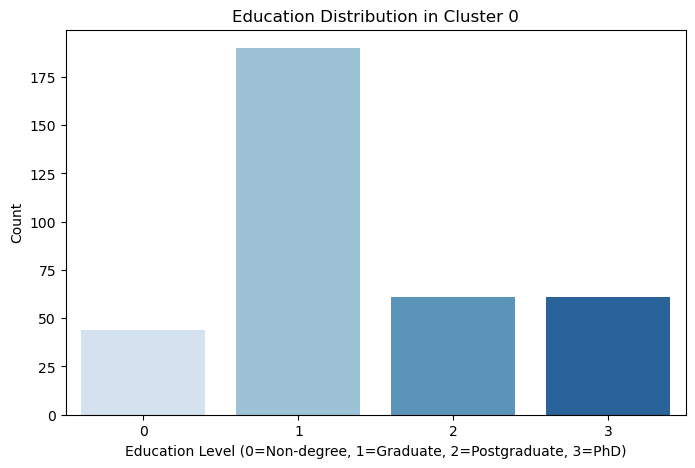

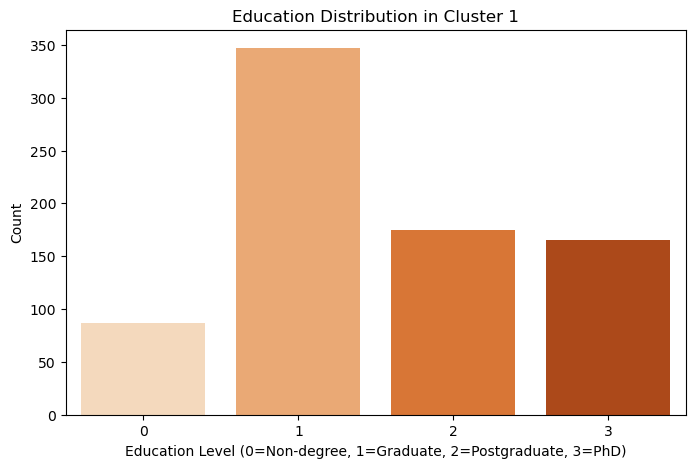

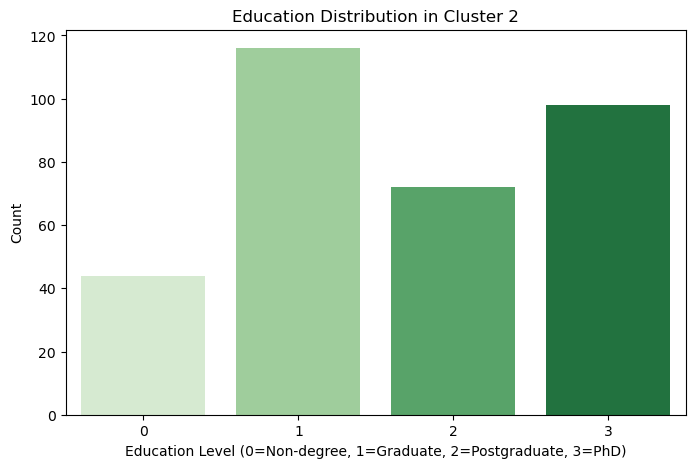

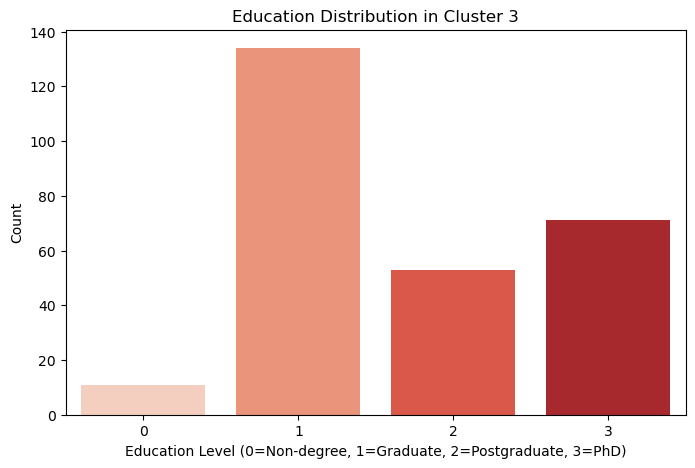

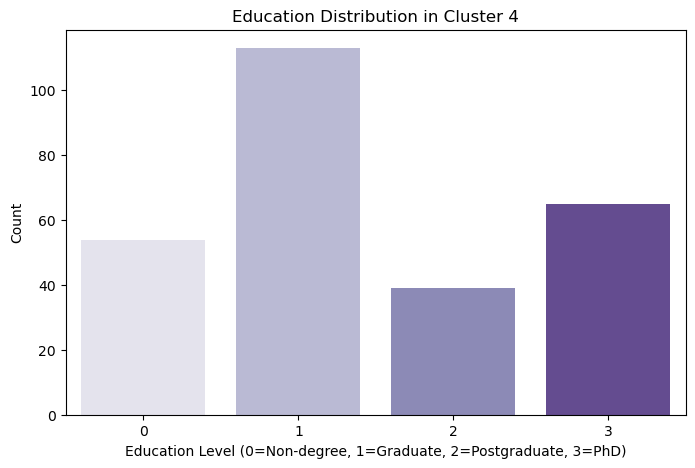

In [161]:
for cluster in range(5):
    plt.figure(figsize=(8, 5))
    sns.countplot(x='education', data=df3[df3['cluster'] == cluster], palette=f'{['Blues', 'Oranges', 'Greens', 'Reds', 'Purples'][cluster]}')
    plt.title(f'Education Distribution in Cluster {cluster}')
    plt.xlabel('Education Level (0=Non-degree, 1=Graduate, 2=Postgraduate, 3=PhD)')
    plt.ylabel('Count')
    plt.show()

# Week 4 assignment: NLP using Python

In [163]:
# Verify review and summary columns
df = pd.read_csv('turtle_reviews.csv')
print(df[['review', 'summary']].info())
print(df[['review', 'summary']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   review   2000 non-null   object
 1   summary  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None
                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  
0  The fact that 50% of this space is wasted on a...  
1  Another worthless Dungeon Master's screen from...  
2                    pretty, but also pretty useless  
3                                         Five Stars  
4                                         Money trap  


In [169]:
# Download NLTK resources
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sharo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [179]:
# Preprocess text columns
df['review'] = df['review'].str.lower().str.replace(f'[{string.punctuation}]', '', regex=True)
df['summary'] = df['summary'].str.lower().str.replace(f'[{string.punctuation}]', '', regex=True)
df = df.drop_duplicates(subset=['review', 'summary'])
print(df[['review', 'summary']].head())

                                              review  \
0  when it comes to a dms screen the space on the...   
1  an open letter to galeforce9\n\nyour unpainted...   
2  nice art nice printing  why two panels are fil...   
3  amazing buy bought it as a gift for our new dm...   
4  as my review of gf9s previous screens these we...   

                                             summary  
0  the fact that 50 of this space is wasted on ar...  
1  another worthless dungeon masters screen from ...  
2                     pretty but also pretty useless  
3                                         five stars  
4                                         money trap  


In [185]:
from nltk.stem import WordNetLemmatizer

In [189]:
# Lemmatize text columns
lemmatizer = WordNetLemmatizer()
df['review'] = df['review'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))
df['summary'] = df['summary'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

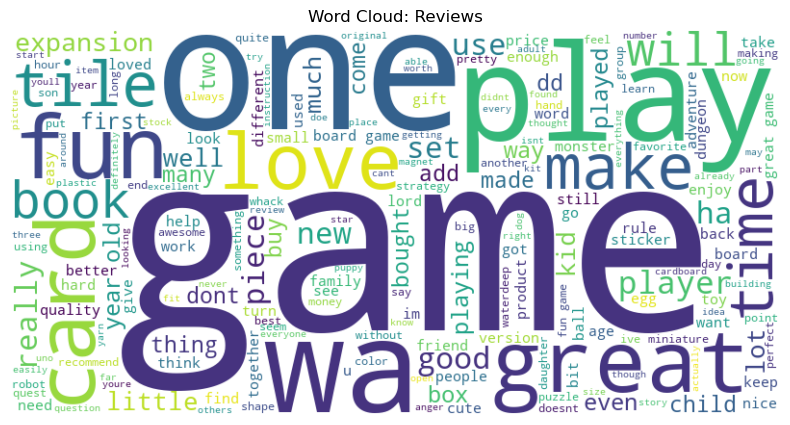

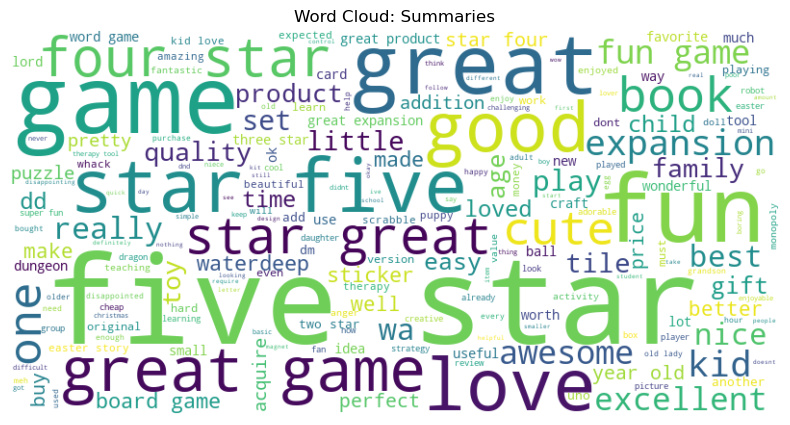

In [207]:
# Import NLTK tokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Create word clouds for reviews and summaries
df_nlp = df.copy()  # Work on a copy to preserve original
df_nlp['review_tokens'] = df_nlp['review'].apply(word_tokenize)
df_nlp['summary_tokens'] = df_nlp['summary'].apply(word_tokenize)

# Generate review word cloud
review_text = ' '.join(df_nlp['review'])
wordcloud_review = WordCloud(width=800, height=400, background_color='white').generate(review_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_review, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Reviews')
plt.show()

# Generate summary word cloud
summary_text = ' '.join(df_nlp['summary'])
wordcloud_summary = WordCloud(width=800, height=400, background_color='white').generate(summary_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Summaries')
plt.show()

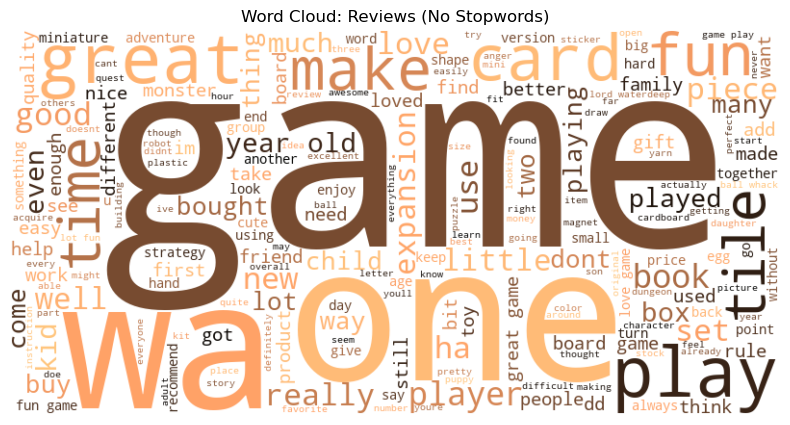

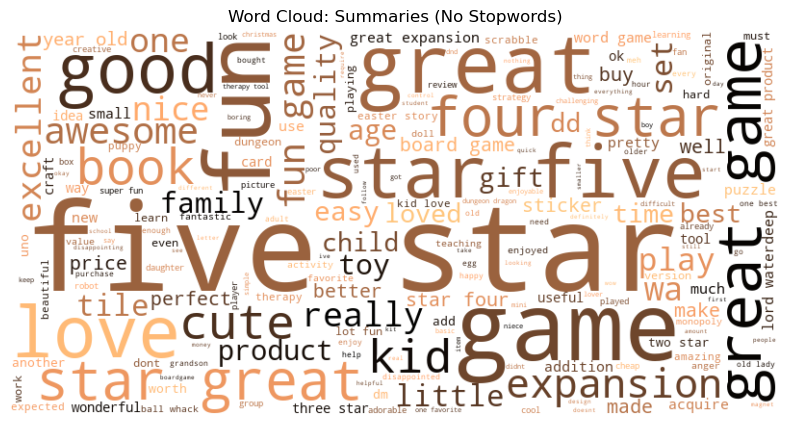

Top 15 Review Words: [('game', 1927), ('great', 580), ('one', 572), ('wa', 567), ('fun', 552), ('play', 542), ('love', 469), ('like', 434), ('card', 431), ('tile', 400), ('get', 369), ('time', 359), ('make', 334), ('really', 319), ('book', 316)]
Top 15 Summary Words: [('star', 439), ('five', 342), ('game', 334), ('great', 295), ('fun', 218), ('love', 114), ('good', 92), ('expansion', 61), ('four', 58), ('like', 55), ('kid', 52), ('book', 46), ('cute', 45), ('one', 43), ('product', 37)]


In [212]:
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from textblob import TextBlob

# Frequency distribution and word clouds without stopwords
stop_words = set(stopwords.words('english'))
review_words = [word for tokens in df_nlp['review_tokens'] for word in tokens if word.isalpha() and word not in stop_words]
summary_words = [word for tokens in df_nlp['summary_tokens'] for word in tokens if word.isalpha() and word not in stop_words]

wordcloud_review = WordCloud(width=800, height=400, background_color='white', colormap='copper').generate(' '.join(review_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_review, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Reviews (No Stopwords)')
plt.show()

wordcloud_summary = WordCloud(width=800, height=400, background_color='white', colormap='copper').generate(' '.join(summary_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Summaries (No Stopwords)')
plt.show()

freq_dist_review = FreqDist(review_words)
freq_dist_summary = FreqDist(summary_words)
print("Top 15 Review Words:", freq_dist_review.most_common(15))
print("Top 15 Summary Words:", freq_dist_summary.most_common(15))

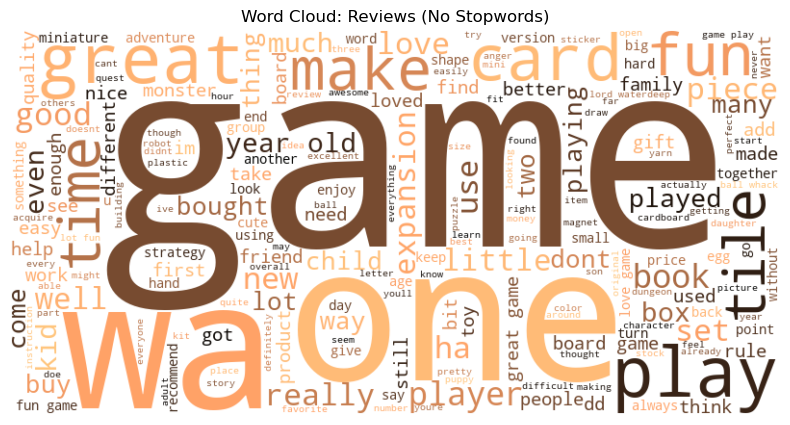

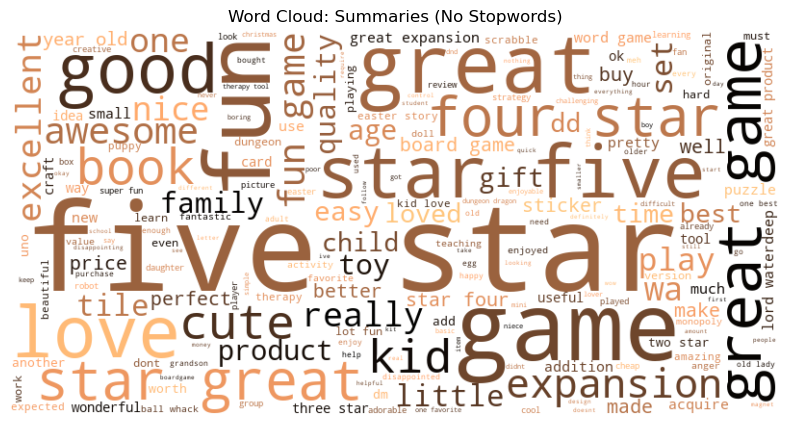

Top 15 Review Words: [('game', 1927), ('great', 580), ('one', 572), ('wa', 567), ('fun', 552), ('play', 542), ('love', 469), ('like', 434), ('card', 431), ('tile', 400), ('get', 369), ('time', 359), ('make', 334), ('really', 319), ('book', 316)]
Top 15 Summary Words: [('star', 439), ('five', 342), ('game', 334), ('great', 295), ('fun', 218), ('love', 114), ('good', 92), ('expansion', 61), ('four', 58), ('like', 55), ('kid', 52), ('book', 46), ('cute', 45), ('one', 43), ('product', 37)]


In [212]:
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from textblob import TextBlob

# Frequency distribution and word clouds without stopwords
stop_words = set(stopwords.words('english'))
review_words = [word for tokens in df_nlp['review_tokens'] for word in tokens if word.isalpha() and word not in stop_words]
summary_words = [word for tokens in df_nlp['summary_tokens'] for word in tokens if word.isalpha() and word not in stop_words]

wordcloud_review = WordCloud(width=800, height=400, background_color='white', colormap='copper').generate(' '.join(review_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_review, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Reviews (No Stopwords)')
plt.show()

wordcloud_summary = WordCloud(width=800, height=400, background_color='white', colormap='copper').generate(' '.join(summary_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Summaries (No Stopwords)')
plt.show()

freq_dist_review = FreqDist(review_words)
freq_dist_summary = FreqDist(summary_words)
print("Top 15 Review Words:", freq_dist_review.most_common(15))
print("Top 15 Summary Words:", freq_dist_summary.most_common(15))

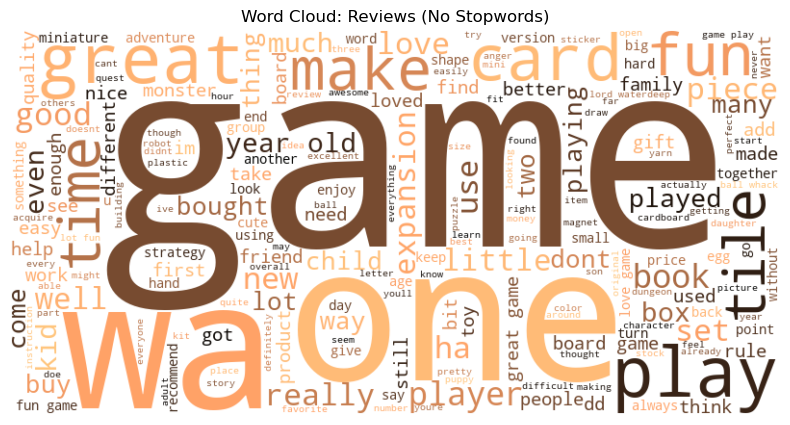

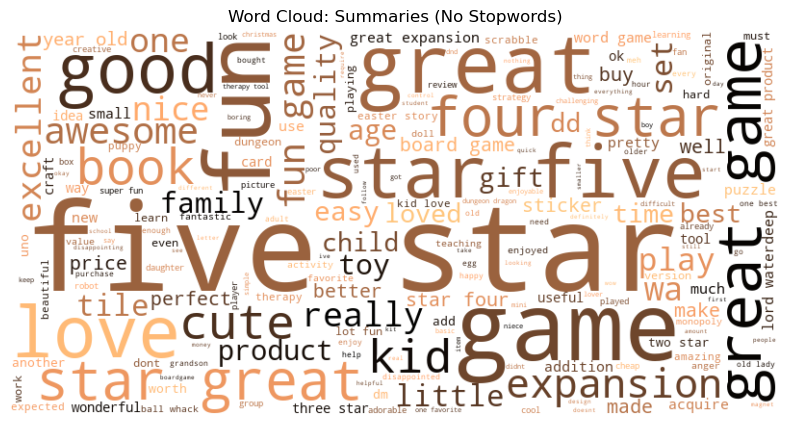

Top 15 Review Words: [('game', 1927), ('great', 580), ('one', 572), ('wa', 567), ('fun', 552), ('play', 542), ('love', 469), ('like', 434), ('card', 431), ('tile', 400), ('get', 369), ('time', 359), ('make', 334), ('really', 319), ('book', 316)]
Top 15 Summary Words: [('star', 439), ('five', 342), ('game', 334), ('great', 295), ('fun', 218), ('love', 114), ('good', 92), ('expansion', 61), ('four', 58), ('like', 55), ('kid', 52), ('book', 46), ('cute', 45), ('one', 43), ('product', 37)]


In [212]:
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from textblob import TextBlob

# Frequency distribution and word clouds without stopwords
stop_words = set(stopwords.words('english'))
review_words = [word for tokens in df_nlp['review_tokens'] for word in tokens if word.isalpha() and word not in stop_words]
summary_words = [word for tokens in df_nlp['summary_tokens'] for word in tokens if word.isalpha() and word not in stop_words]

wordcloud_review = WordCloud(width=800, height=400, background_color='white', colormap='copper').generate(' '.join(review_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_review, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Reviews (No Stopwords)')
plt.show()

wordcloud_summary = WordCloud(width=800, height=400, background_color='white', colormap='copper').generate(' '.join(summary_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Summaries (No Stopwords)')
plt.show()

freq_dist_review = FreqDist(review_words)
freq_dist_summary = FreqDist(summary_words)
print("Top 15 Review Words:", freq_dist_review.most_common(15))
print("Top 15 Summary Words:", freq_dist_summary.most_common(15))

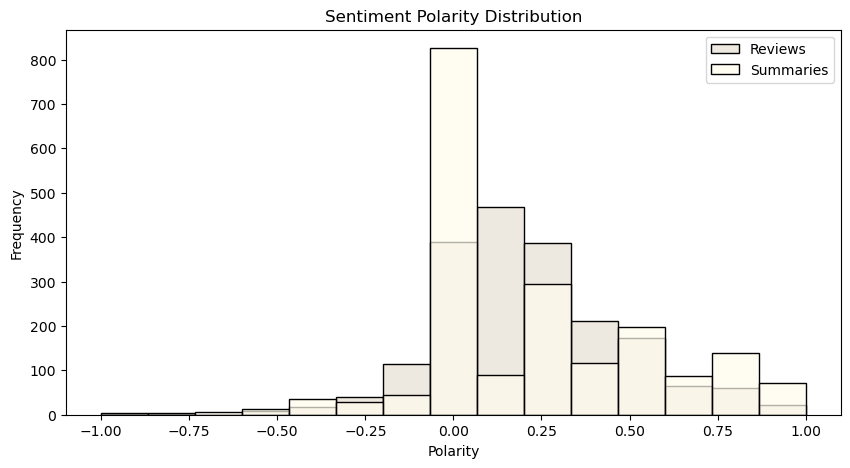

Review Polarity Stats:
 count    1961.000000
mean        0.209193
std         0.255507
min        -1.000000
25%         0.043854
50%         0.174851
75%         0.350000
max         1.000000
Name: review_polarity, dtype: float64
Summary Polarity Stats:
 count    1961.000000
mean        0.221468
std         0.335388
min        -1.000000
25%         0.000000
50%         0.100000
75%         0.466667
max         1.000000
Name: summary_polarity, dtype: float64


In [214]:
# Sentiment polarity analysis
beige_pastels = ['#d0c5b9', '#dcd3c6', '#e8e0d3', '#f3eee0', '#fffbed']
df_nlp['review_polarity'] = df_nlp['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_nlp['summary_polarity'] = df_nlp['summary'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 5))
sns.histplot(df_nlp['review_polarity'], bins=15, color=beige_pastels[2], label='Reviews', alpha=0.7)
sns.histplot(df_nlp['summary_polarity'], bins=15, color=beige_pastels[4], label='Summaries', alpha=0.7)
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.title('Sentiment Polarity Distribution')
plt.legend()
plt.show()

print("Review Polarity Stats:\n", df_nlp['review_polarity'].describe())
print("Summary Polarity Stats:\n", df_nlp['summary_polarity'].describe())

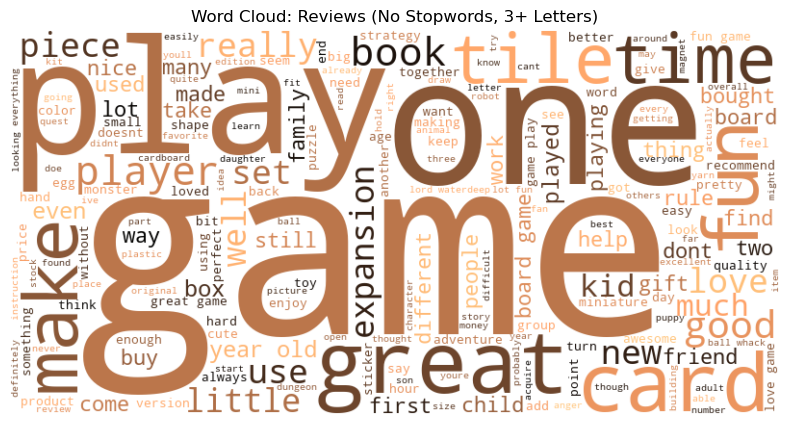

Top 15 Review Words: [('game', 1927), ('great', 580), ('one', 572), ('fun', 552), ('play', 542), ('love', 469), ('like', 434), ('card', 431), ('tile', 400), ('get', 369), ('time', 359), ('make', 334), ('really', 319), ('book', 316), ('set', 292)]


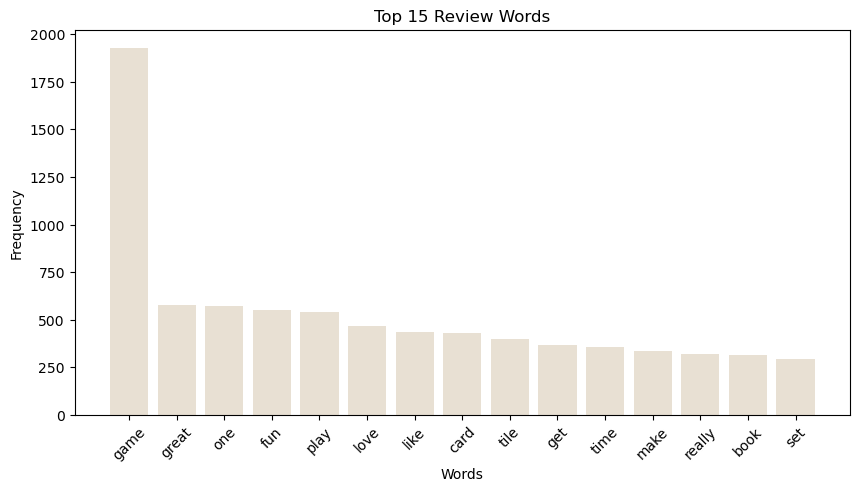

In [215]:
# Frequency distribution with refined cleaning
stop_words = set(stopwords.words('english'))
review_words = [word for tokens in df_nlp['review_tokens'] for word in tokens if word.isalpha() and word.lower() not in stop_words and len(word) >= 3]

wordcloud_review = WordCloud(width=800, height=400, background_color='white', colormap='copper').generate(' '.join(review_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_review, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Reviews (No Stopwords, 3+ Letters)')
plt.show()

freq_dist_review = FreqDist(review_words)
top_15 = freq_dist_review.most_common(15)
print("Top 15 Review Words:", top_15)

plt.figure(figsize=(10, 5))
plt.bar([word for word, _ in top_15], [count for _, count in top_15], color=beige_pastels[2])
plt.xticks(rotation=45)
plt.title('Top 15 Review Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [218]:
# Sentiment subjectivity and thematic analysis
df_nlp['review_subjectivity'] = df_nlp['review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
print("Top 20 Positive Reviews:\n", df_nlp.nlargest(20, 'review_polarity')[['review', 'review_polarity', 'review_subjectivity']])

top_negative = df_nlp.nsmallest(20, 'review_polarity')[['review', 'review_polarity']]
top_negative['theme'] = top_negative['review'].apply(
    lambda x: 'Delivery' if 'delivery' in x else 'Product Quality' if 'quality' in x or 'product' in x else 'Other')
print("Negative Review Themes:\n", top_negative.groupby('theme').size())

Top 20 Positive Reviews:
                                                  review  review_polarity  \
7                             came in perfect condition            1.000   
165                                        awesome book            1.000   
194                                        awesome gift            1.000   
496   excellent activity for teaching selfmanagement...            1.000   
524                         perfect just what i ordered            1.000   
591                                   wonderful product            1.000   
609                                  delightful product            1.000   
621   wonderful for my grandson to learn the resurre...            1.000   
790                                             perfect            1.000   
933                                             awesome            1.000   
1135                                        awesome set            1.000   
1177               awesome addition to my rpg gm system       